In [7]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm 
pd.options.plotting.backend = "plotly"
from torch import nn, optim
from torch.autograd import Variable


In [4]:
def data_transforms(phase=None):
    if phase == TRAIN:
        data_T = T.Compose([
            T.Resize(size=(256,256)),
            T.RandomRotation(degrees=(-20, +20)),
            T.CenterCrop(size=224),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.209, 0.224, 0.225])
        ])
    elif phase == TEST or phase == VAL:
        data_T = T.Compose([
            T.Resize(size=(224,224)),
            T.ToTensor(),
            T.Normalize([0,485, 0.456, 0.406], [0.209, 0.224, 0.225])
        ])
    
    return data_T


In [5]:
data_dir = "./chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL = 'val'

trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN), transform=data_transforms(TRAIN))
testset = datasets.ImageFolder(os.path.join(data_dir, TEST),transform = data_transforms(TEST))
validset = datasets.ImageFolder(os.path.join(data_dir, VAL),transform = data_transforms(VAL))

In [6]:
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [9]:
trainloader = DataLoader(trainset, batch_size= 64, shuffle=True)
validloader = DataLoader(validset, batch_size= 64, shuffle=True)
testloader = DataLoader(testset, batch_size= 64, shuffle=True)

iter_data=  iter(trainloader)
images, labels = next(iter_data)
print(images.shape)
print(labels.shape)


torch.Size([64, 3, 224, 224])
torch.Size([64])


In [10]:
for i, (images, labels) in enumerate(trainloader):
    if torch.cuda.is_available():
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

In [11]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [27]:
class classify(nn.Module):
    def __init__(self, num_classes=2):
        super(classify, self).__init__()

        self.conv1=nn.Conv2d(in_channels=3, out_channels=21, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=21)
        self.relu1 = nn.ReLU()
        self.pool1=  nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=21, out_channels=42, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=42, out_channels=60, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=60)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(in_features=60*112*112, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)

        output = output.view(-1, 60*112*112)
        output = self.fc(output)

        return output
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [28]:
model = classify()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    

In [29]:
model_weights = []
conv_layers = []

model_children = list(model.children())
counter = 0

for i in range(len(model_children)):
    if type(model_children[i])== nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter +=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(model_weights)

Total convolution layers: 3
[Parameter containing:
tensor([[[[ 1.8505e-02, -2.3036e-04, -1.3351e-01],
          [-1.3756e-01, -4.2870e-02,  6.9951e-02],
          [ 1.2708e-01,  1.2128e-01, -4.4087e-02]],

         [[-1.8253e-01,  8.4202e-02, -2.5793e-02],
          [ 1.1851e-01,  4.9610e-02,  1.0433e-01],
          [ 2.5092e-02,  1.9118e-01, -8.7039e-02]],

         [[ 1.0282e-01, -1.8967e-01,  2.2374e-02],
          [-8.4116e-02,  1.6254e-01,  1.2256e-02],
          [-1.1379e-01, -1.0380e-01, -1.4115e-02]]],


        [[[ 8.4288e-02,  5.1477e-02,  1.1364e-01],
          [ 1.4163e-01, -7.8654e-02, -1.1878e-01],
          [ 1.4343e-01,  8.3009e-02,  1.8111e-01]],

         [[ 8.1452e-03,  1.1648e-01,  4.7813e-04],
          [ 1.0788e-01, -1.7055e-01, -7.2243e-02],
          [ 1.5096e-01,  1.0836e-01, -1.9873e-02]],

         [[-1.7877e-01, -7.1443e-02,  1.6083e-01],
          [ 4.7930e-02, -2.6721e-02, -1.1107e-01],
          [ 1.7351e-01,  1.3153e-01,  7.2701e-02]]],


        [[[-1.6

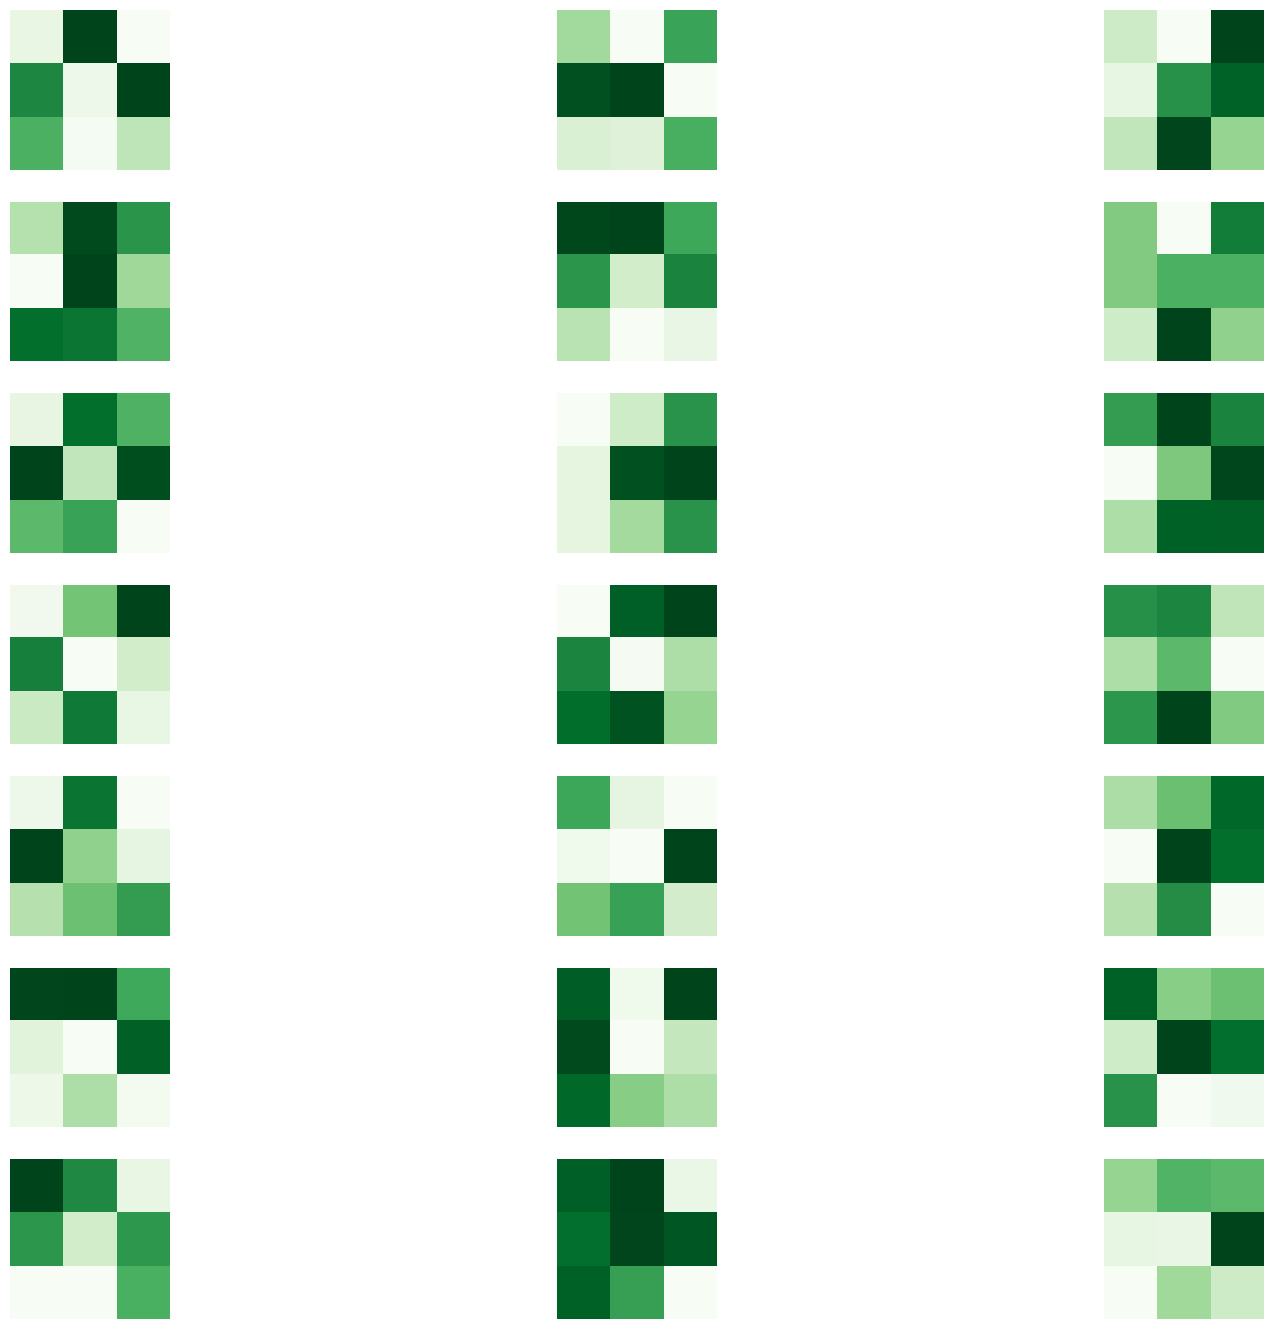

In [20]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(7, 3, i+1) #(7, 2) because in conv0 we have 3x3 filters and total of 21 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='Greens')
    plt.axis('off')
    plt.savefig('filter.png')
plt.show()

torch.Size([21, 224, 224])
Saving layer 0 feature maps...


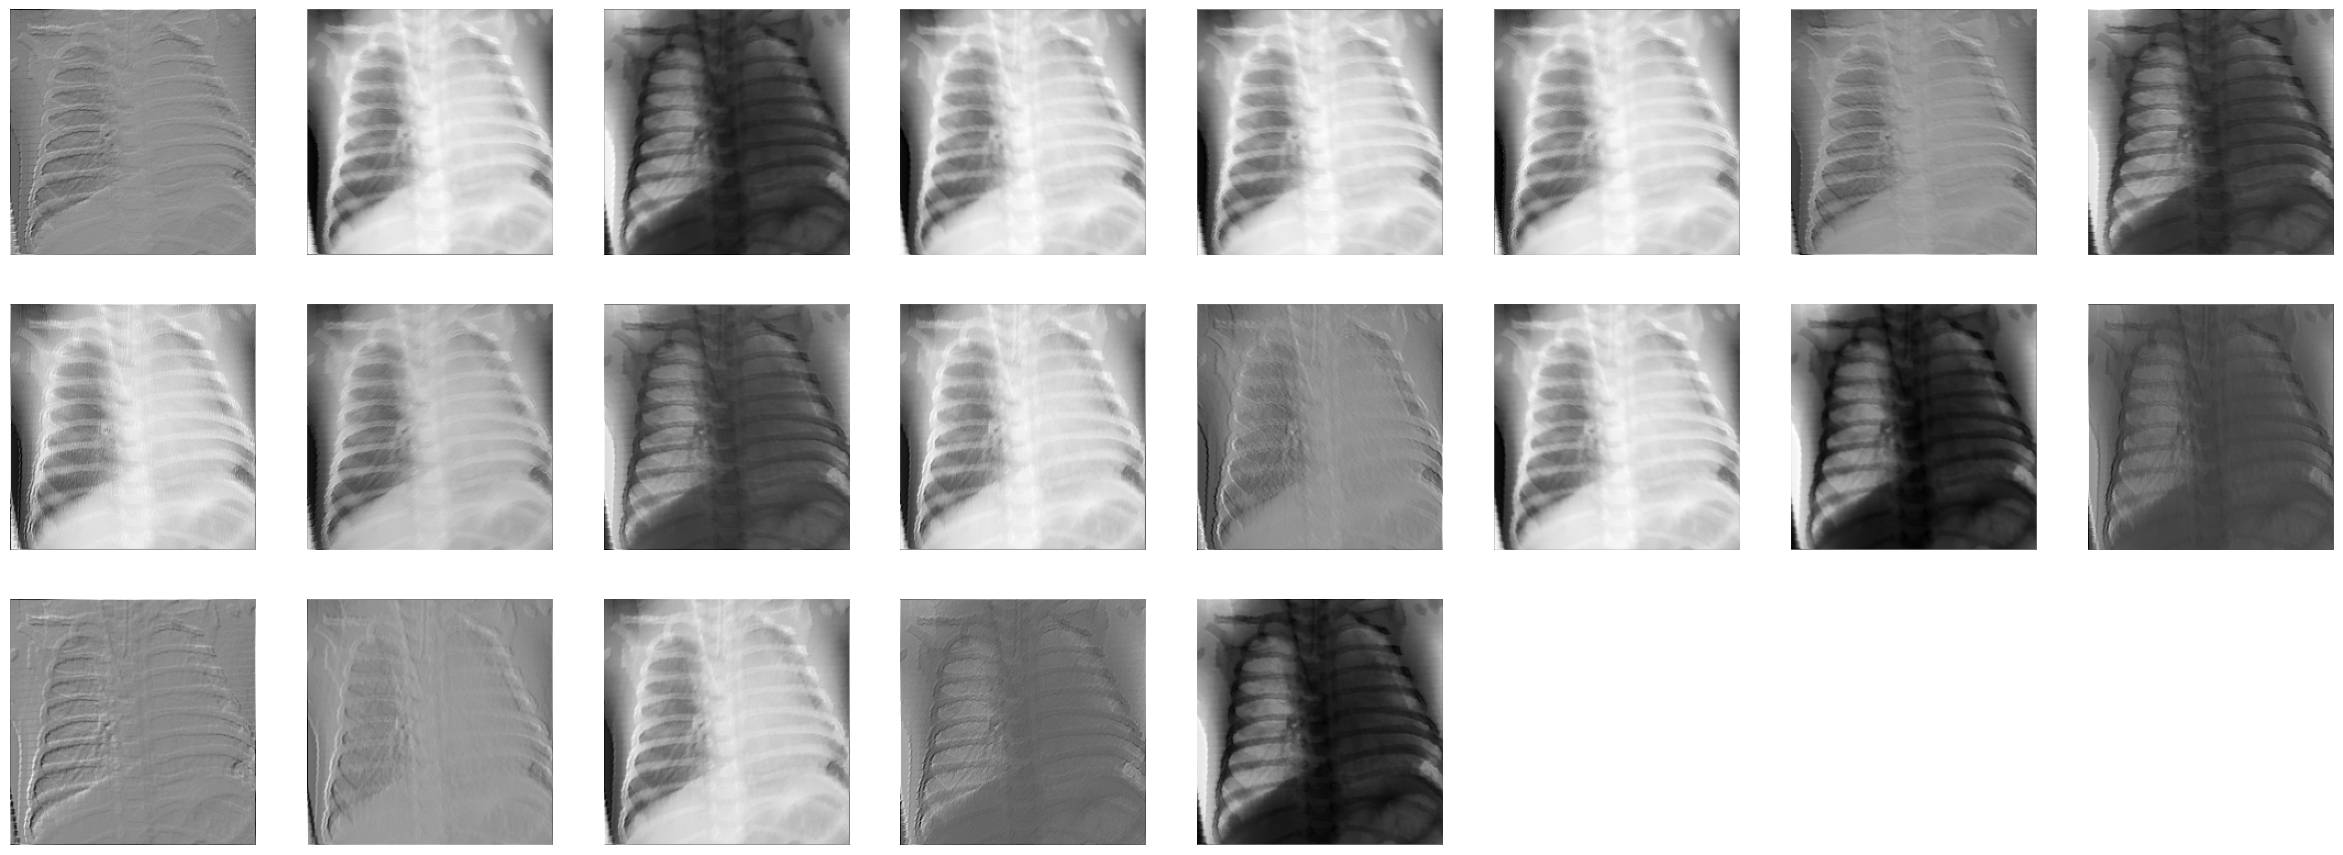

torch.Size([42, 224, 224])
Saving layer 1 feature maps...


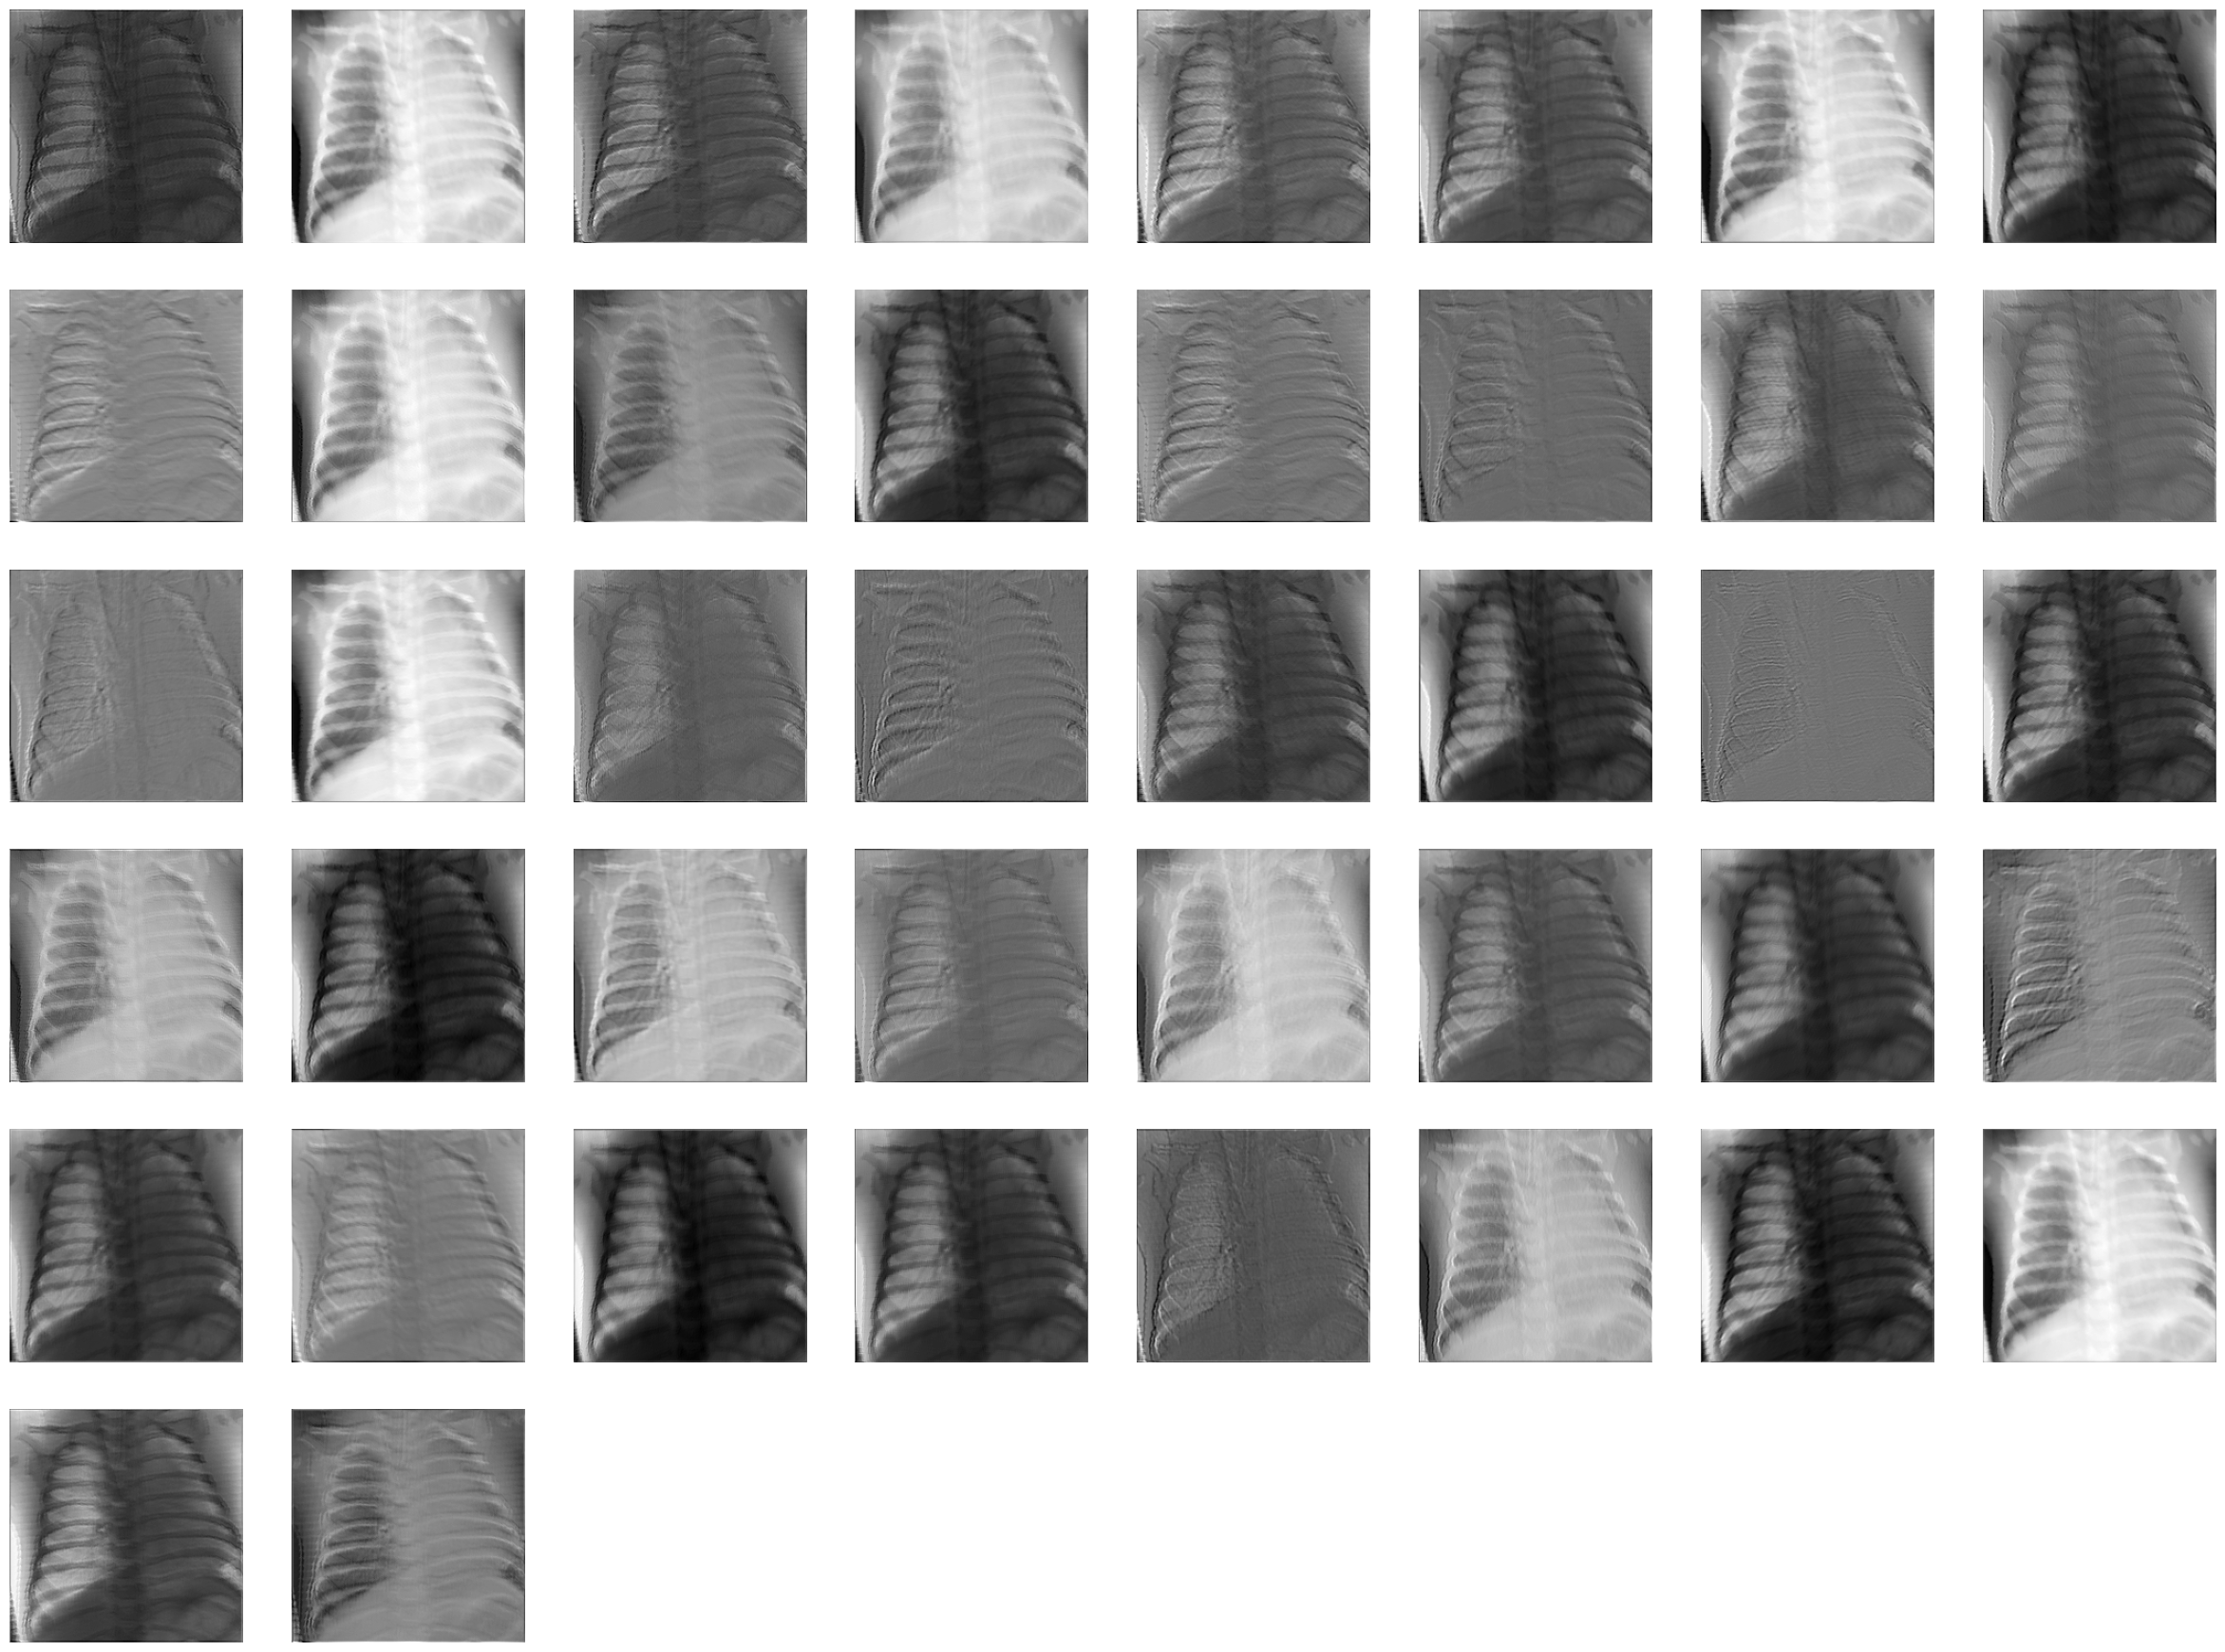

torch.Size([60, 224, 224])
Saving layer 2 feature maps...


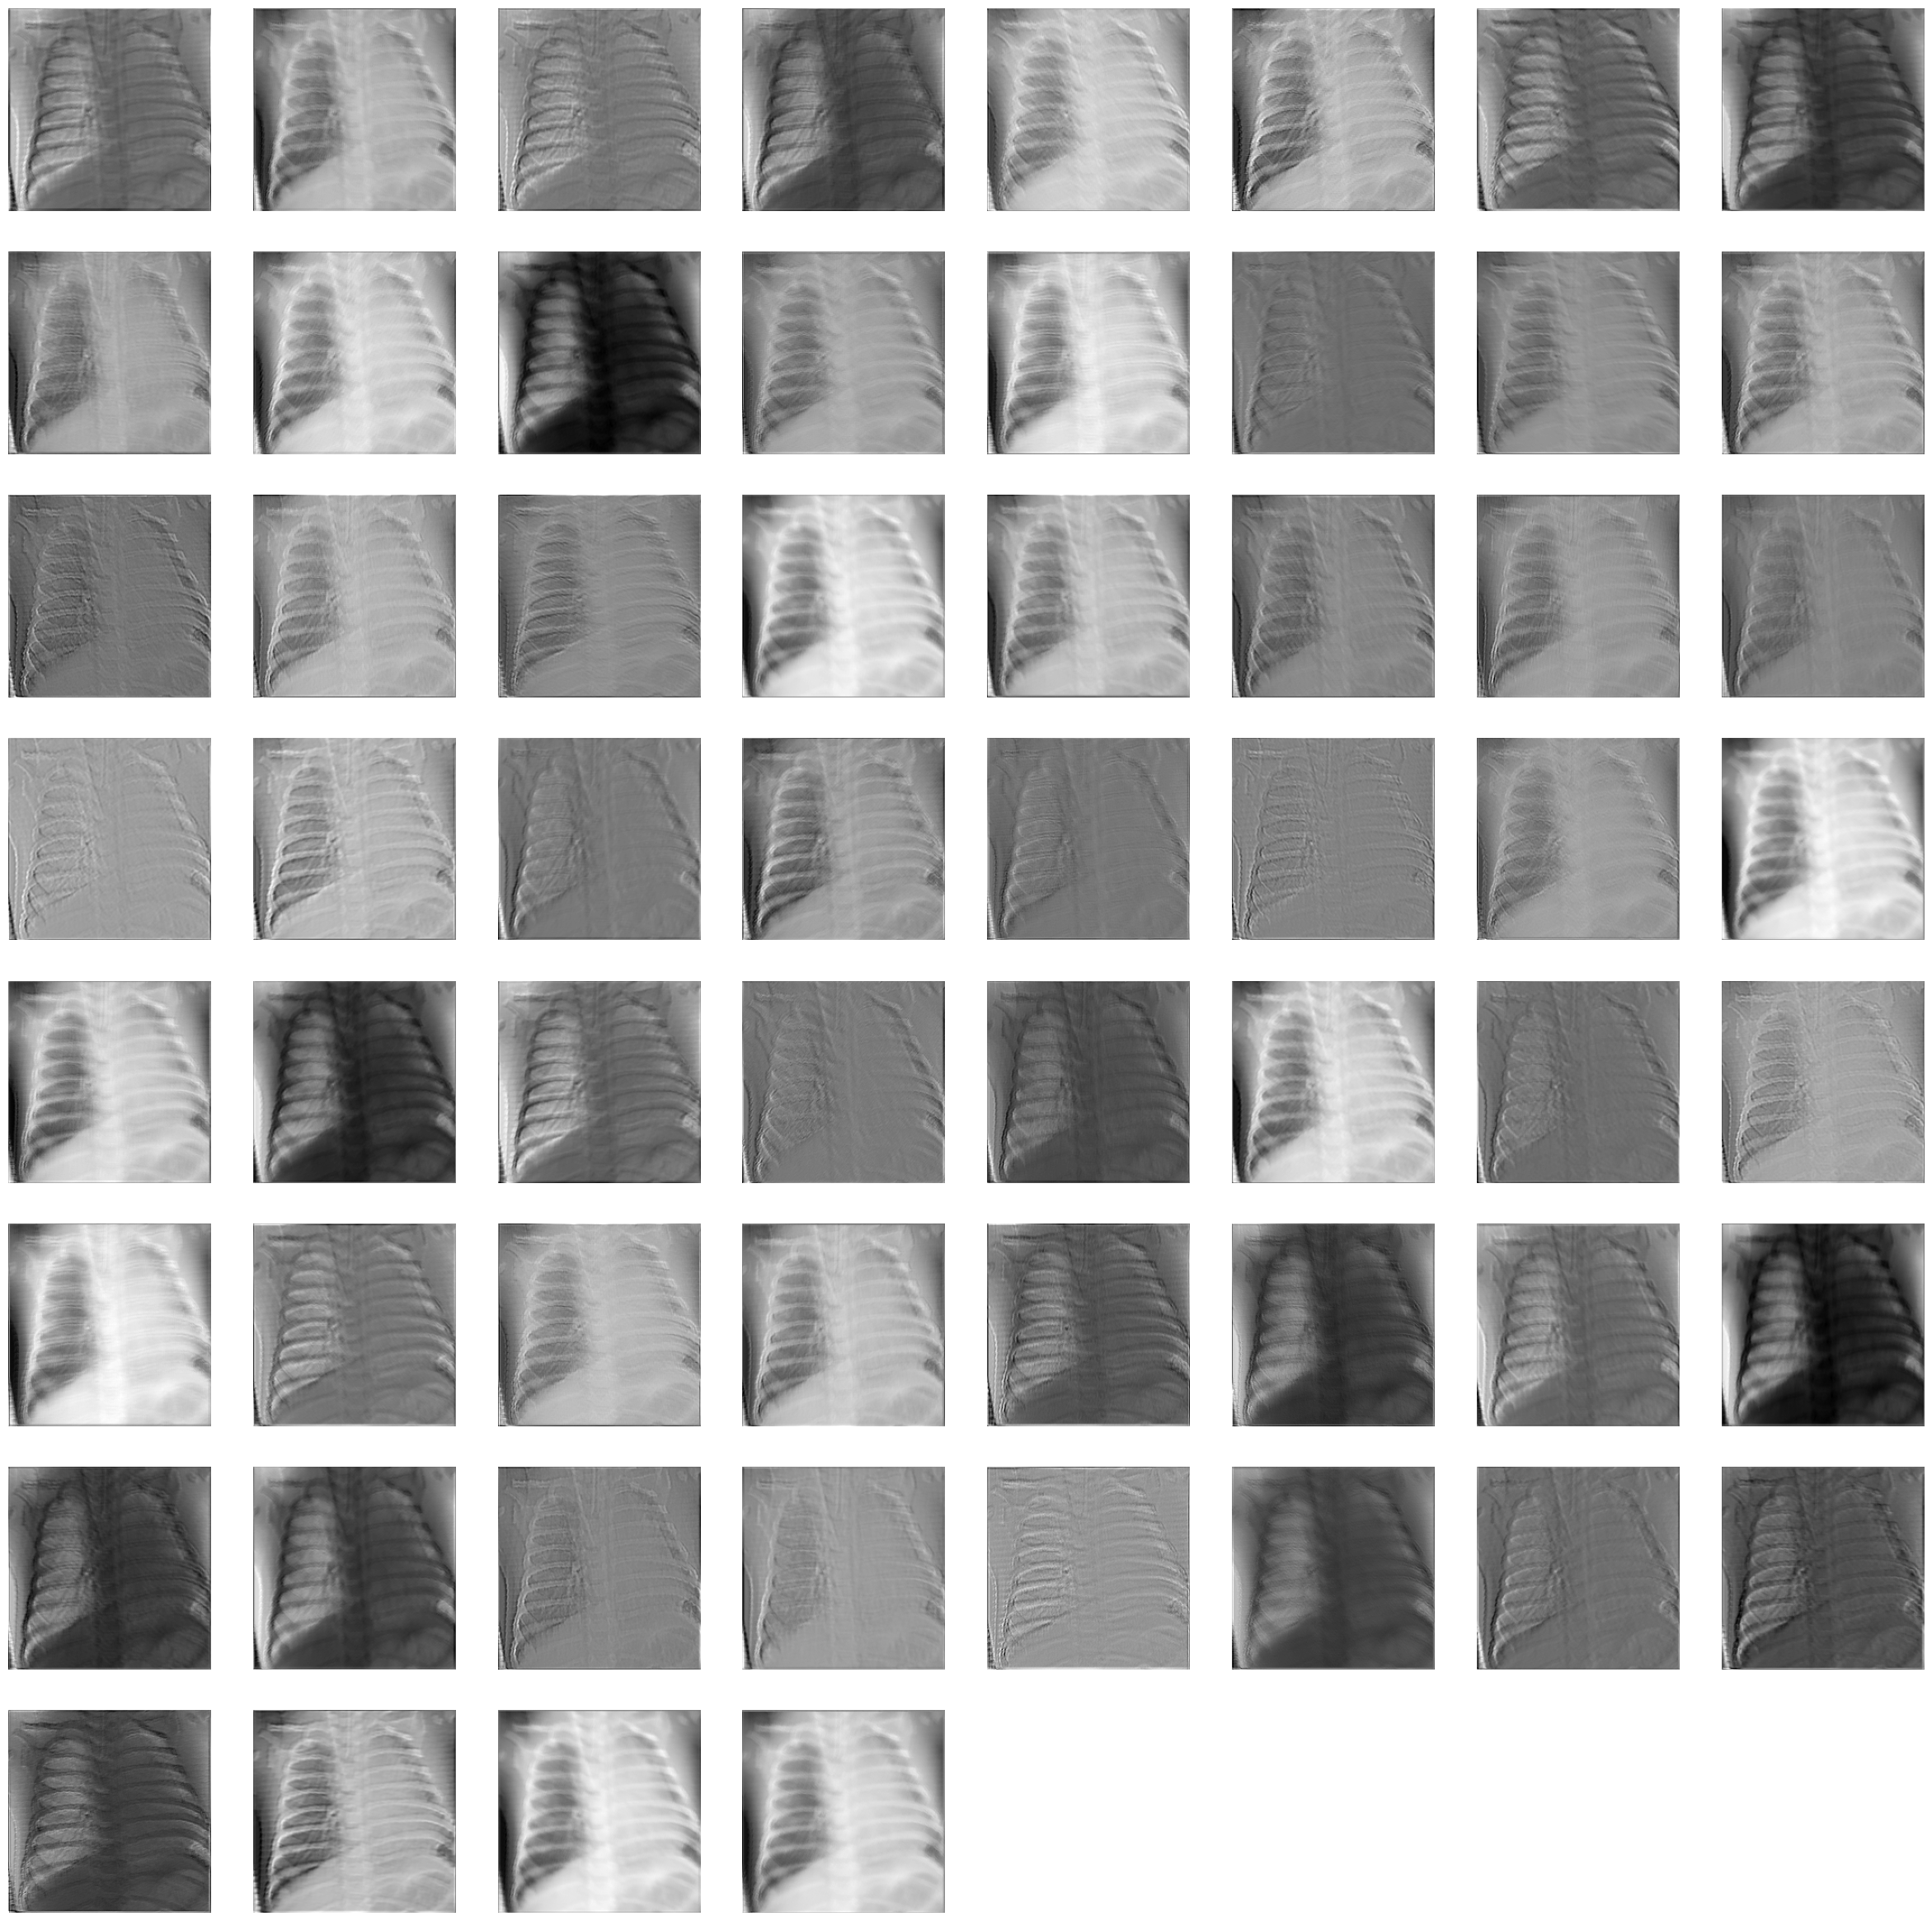

In [30]:
results = [conv_layers[0](images)]
outputs = results

for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))


for num_layer in range(len(outputs)):
    plt.figure(figsize=(30,30))
    layer_viz = outputs[num_layer][0, :, :,:]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i ==64:
            break
        plt.subplot(8,8, i+1)
        plt.imshow(filter, cmap='gray')
        plt.axis('off')
    print(f"Saving layer {num_layer} feature maps...")
    plt.show()
    plt.close()

In [31]:
Losses = []
for i in range(8):
    running_loss = 0
    for images, labels in trainloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = images.cuda()

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        Losses.append(loss)

        running_loss += loss.item()
    else:
        T_Loss = running_loss/len(trainloader)
        print("Epoch {} - Training loss: {}".format(i+1, T_Loss))


Epoch 1 - Training loss: 95.36170768519727
Epoch 2 - Training loss: 20.20612737413768
Epoch 3 - Training loss: 18.15290431496574
Epoch 4 - Training loss: 6.292590729553655
Epoch 5 - Training loss: 2.780689945364961
Epoch 6 - Training loss: 1.7162999797067886
Epoch 7 - Training loss: 1.1792091544640229
Epoch 8 - Training loss: 0.9472562986731659
